# Urban Data Final Project 

Olena Bogdanov (ob234) | Yuchen Ye (_______)

**TL;DR:**
- Prepared MTA turnstile data from Jan 2018 to Jan 2022. 
- Cleaned the data by renaming columns, adding calculated fields, removing erroneous data and aggregating by station and date.
- Found that weekdays had the highest traffic, but this was less the case for some stations; certain days also had anomalous traffic flows.
- Anomalies, time of day and other sources of demographic data should be considered for further analysis. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pickle

%matplotlib inline

- Grabbing data from MTA website. Total data used was 208 weeks from Jan 2018 to Jan 2022 
- For the final dataset, all 208 rows were used, however the commented out code allows for using a limited dataset (3 weeks worth) 

In [3]:
#initialise the number of weeks for the dataset
num_weeks = 208

#initialise the date for the first week of the dataset (week ending on start_date)
start_date = filedate = pd.Timestamp('2018-01-06 00:00:00')

#initialise the regex for the MTA turnstile url
filename_regex = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"

filelist = []

for numfiles in range (num_weeks):

    # create the appropriate filename for the week
    filedate_str = str(filedate.year)[2:4] + str(filedate.month).zfill(2) + str(filedate.day).zfill(2)
    filename = filename_regex.format(filedate_str)

    # read the file and append it to the list of files to be concacated
    df = pd.read_csv(filename, parse_dates=['DATE'], keep_date_col=True)
    filelist.append(df)

    # advance to the next week
    filedate += pd.Timedelta(days=7)

turnstiles_df = pd.concat(filelist, axis=0, ignore_index=True)


In [ ]:
''' #Limited Dataset 
# Source: http://web.mta.info/developers/dfturnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [221029, 221105, 221112]
turnstiles_df = get_data(week_nums)
'''

In [5]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,03:00:00,REGULAR,6463109,2187558
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,07:00:00,REGULAR,6463119,2187567
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,11:00:00,REGULAR,6463178,2187654
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,15:00:00,REGULAR,6463373,2187736
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,19:00:00,REGULAR,6463712,2187803


We see that there are entries and exits for each unit, every day at different hours of the day. If we could use this data to find the numbers of entries for each station, we could find which stations are the most popular. Let's start with this goal in mind.

There is an explanation of the column headers from the MTA website:

C/A - Control Area name/Booth name. This is the internal identification of a booth at a given station.
Unit - Remote unit ID of station.
SCP - Subunit/Channel/position represents a specific address for a given device. STATION - Name assigned to the subway station by operations planning. This name is used in all references to stations, as well as in debit/credit purchase receipts, and customer’s bank activity statements.
LINENAME - Train lines stopping at this location. Can contain up to 20 single character identifier. When more than one train line appears, it is usually intercepting train lines, in major stations where the passenger can transfer between any one of the lines.
DIVISION - Represents the Line originally the station belonged to BMT, IRT, or IND. Each section of the system is assigned a unique line name, usually paired with its original operating company or division (Brooklyn–Manhattan Transit Corporation (BMT), Interborough Rapid Transit Company (IRT), and Independent Subway System (IND).
DATE - Represents the date of the audit data.

In [6]:
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [7]:
# Let's strip out the white space that may be surronding the column names.
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [8]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,03:00:00,REGULAR,6463109,2187558
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,07:00:00,REGULAR,6463119,2187567
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,11:00:00,REGULAR,6463178,2187654
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,15:00:00,REGULAR,6463373,2187736
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,19:00:00,REGULAR,6463712,2187803


In [9]:
#Now let's check to see that everyday is represented and how many times it is represented. We see below that some days have larger counts than others.

In [10]:
turnstiles_df.DATE.value_counts().sort_index()

2017-12-30    28206
2017-12-31    28076
2018-01-01    28157
2018-01-02    28103
2018-01-03    28104
              ...  
2021-12-20    30120
2021-12-21    30015
2021-12-22    30005
2021-12-23    30232
2021-12-24    29969
Name: DATE, Length: 1456, dtype: int64

In [12]:
# turn date and time into datetimes 
# turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, format="%m/%d/%Y %H:%M:%S")

In [13]:
# new column called DATE_TIME
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,03:00:00,REGULAR,6463109,2187558
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,07:00:00,REGULAR,6463119,2187567
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,11:00:00,REGULAR,6463178,2187654
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,15:00:00,REGULAR,6463373,2187736
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,19:00:00,REGULAR,6463712,2187803


The SCP represents a single turnstile, however, the SCP is a subunit of the station, unit, and C/A. Therefore, all four of these need to be grouped together along with the date time in order to get the entries and exits for each turnstile. If these four items are grouped together and there are duplicates, that must mean something went wrong with the turnstyle because it gave multiple outputs for the same date and time.

In [14]:
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"])  
 .ENTRIES.count()
 .reset_index()  # or use as_index = False; otherwise makes groupby columns new index 
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
1150789,A035,R170,00-00-01,14 ST-UNION SQ,2019-03-27,17:00:00,2
42351413,S101,R070,00-00-02,ST. GEORGE,2021-08-30,08:00:00,2
2414206,A064,R311,00-03-01,BOWERY,2020-08-17,16:00:00,2
11413862,N071,R013,00-00-04,34 ST-PENN STA,2019-04-20,08:00:00,2
2414205,A064,R311,00-03-01,BOWERY,2020-08-17,12:00:00,2


In [17]:
''' #part of the original/lightweight analysis 
# 2 of the same entries on 2022-10-30, why
mask = ((turnstiles_df["C/A"] == "R417") & 
(turnstiles_df["UNIT"] == "R222") & 
(turnstiles_df["SCP"] == "00-00-01") & 
(turnstiles_df["STATION"] == "PARKCHESTER") )
turnstiles_df[mask].head()
'''

' #part of the original/lightweight analysis \n# 2 of the same entries on 2022-10-30, why\nmask = ((turnstiles_df["C/A"] == "R417") & \n(turnstiles_df["UNIT"] == "R222") & \n(turnstiles_df["SCP"] == "00-00-01") & \n(turnstiles_df["STATION"] == "PARKCHESTER") )\nturnstiles_df[mask].head()\n'

In [15]:
#incorrect AUD entry? Retrying by selecting Regular 
turnstiles_df.DESC.value_counts()

REGULAR       42514551
RECOVR AUD      180428
Name: DESC, dtype: int64

In [16]:
# Getting rid of duplicates 
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"], inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"], inplace=True)

In [18]:
#check for duplicates 
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2017-12-30,03:00:00,1
28462862,R139,R031,04-06-00,34 ST-PENN STA,2018-10-01,08:00:00,1
28462844,R139,R031,04-06-00,34 ST-PENN STA,2018-09-28,08:00:00,1
28462845,R139,R031,04-06-00,34 ST-PENN STA,2018-09-28,12:00:00,1
28462846,R139,R031,04-06-00,34 ST-PENN STA,2018-09-28,16:00:00,1


In [19]:
# Drop Exits and Desc columns. To prevent errors in multiple run of cell
# These will be processed separately and added later 
# Errors on drop is ignored (e.g. if some columns were dropped already)
turnstiles_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")

In [20]:
# Group the cleaned data by the four identifiers for a single turnstile along with the date to get all the turnstiles at each date 
# Get data for each day 
turnstiles_daily = turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])\
.ENTRIES.first().reset_index()

In [21]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,2017-12-30,6463887
1,A002,R051,02-00-00,59 ST,2017-12-31,6464443
2,A002,R051,02-00-00,59 ST,2018-01-01,6464907
3,A002,R051,02-00-00,59 ST,2018-01-02,6466375
4,A002,R051,02-00-00,59 ST,2018-01-03,6467957


In [22]:
# Transform cumulative to daily entries 
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .transform(lambda grp: grp.shift(1)))
# transform() takes a function as parameter
# shift moves the index by the number of periods given (positive or negative)


<ipython-input-22-359506909023>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily


In [23]:
turnstiles_daily.head()


,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,2017-12-30,6463887,NaT,NaN
1,A002,R051,02-00-00,59 ST,2017-12-31,6464443,2017-12-30,6463887.0
2,A002,R051,02-00-00,59 ST,2018-01-01,6464907,2017-12-31,6464443.0
3,A002,R051,02-00-00,59 ST,2018-01-02,6466375,2018-01-01,6464907.0
4,A002,R051,02-00-00,59 ST,2018-01-03,6467957,2018-01-02,6466375.0


In [24]:
# Drop the rows for first date
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
# axis = 0 means index (=1 means column)

In [25]:
turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].head()


,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
6987,A002,R051,02-03-02,59 ST,2021-03-22,238,2021-03-21,6641395.0
13291,A002,R051,02-05-00,59 ST,2018-08-01,1,2018-07-31,1564.0
13789,A002,R051,02-05-00,59 ST,2019-12-18,12,2019-12-17,216.0
16298,A002,R051,02-06-00,59 ST,2018-11-18,416,2018-11-14,7705439.0
16314,A002,R051,02-06-00,59 ST,2018-12-04,712,2018-12-03,17841.0


In [26]:
# Checking to see how many stations have the problem with reversed entries
(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size()) # size() behaves same as if we'd done .DATE.count() 

C/A    UNIT  SCP       STATION      
A002   R051  02-03-02  59 ST            1
             02-05-00  59 ST            2
             02-06-00  59 ST            6
A006   R079  00-00-04  5 AV/59 ST       1
             00-03-00  5 AV/59 ST       1
                                       ..
TRAM1  R468  00-00-02  RIT-MANHATTAN    2
TRAM2  R469  00-00-00  RIT-ROOSEVELT    1
             00-00-01  RIT-ROOSEVELT    1
             00-03-00  RIT-ROOSEVELT    1
             00-05-00  RIT-ROOSEVELT    1
Length: 1858, dtype: int64

In [27]:
#cleaning entries, capped at 1 million 
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    return counter

# If counter is > 1 million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000) 

# apply takes a function as parameter and applies it along the given axis (1=apply by row) 
# apply takes care of passing each row to the function

238 6641395.0
416 7705439.0
22 7896791.0
60 9437429.0
1011 2997500.0
2170 15256718.0
458795 3408571.0
4 7832194.0
2222 29160757.0
120 885834996.0
197 16816011.0
216 1562636326.0
298 1663107163.0
2536906 1091900.0
52806 17116894.0
9 1562921334.0
0 1663146135.0
3082 1390173.0
50 5264647.0
289 3055256.0
1390 5152545.0
18 4340953.0
12 6170034.0
262204 67148709.0
348 1237351900.0
1713 1553983520.0
117 11715665.0
459077 85175465.0
1279 5664363.0
1443 7054160.0
198 5102094.0
1261 3875856.0
962 2117561.0
738 18398229.0
524514 1535945.0
263 3846402.0
235208427 68073706.0
617 3124306.0
1376864 4960567.0
17 106993519.0
123 1630877.0
644 2234841.0
20 2642748.0
724 3557590.0
3211 5527037.0
1296 1949564336.0
458818 12875905.0
848 1180101.0
459313 11321306.0
305 7251354.0
327680 185586773.0
459468 6999926.0
658 1203534.0
26 3963030.0
6 6777428.0
6 5597786.0
1066 1091335.0
233 1951349.0
169 2172444.0
917 1646681283.0
43 3039842.0
408 4676418.0
29 3367836.0
26 1083967.0
14 1028362.0
512 67586631.0
753 

In [ ]:
#Final result: daily turnstile entries 
#Credit to: https://pylearned.com/SubwayAnalysis/

In [28]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,2017-12-31,6464443,2017-12-30,6463887.0,556.0
2,A002,R051,02-00-00,59 ST,2018-01-01,6464907,2017-12-31,6464443.0,464.0
3,A002,R051,02-00-00,59 ST,2018-01-02,6466375,2018-01-01,6464907.0,1468.0
4,A002,R051,02-00-00,59 ST,2018-01-03,6467957,2018-01-02,6466375.0,1582.0
5,A002,R051,02-00-00,59 ST,2018-01-04,6468797,2018-01-03,6467957.0,840.0


# 
# 
# 

In [ ]:
'''#Doing the same for exit data 
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [221029, 221105, 221112]
exit_df = get_data(week_nums)
'''

In [31]:
#initialise the number of weeks for the dataset
num_weeks = 208

#initialise the date for the first week of the dataset (week ending on start_date)
start_date = filedate = pd.Timestamp('2018-01-06 00:00:00')

#initialise the regex for the MTA turnstile url
filename_regex = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"

filelist = []

for numfiles in range (num_weeks):

    # create the appropriate filename for the week
    filedate_str = str(filedate.year)[2:4] + str(filedate.month).zfill(2) + str(filedate.day).zfill(2)
    filename = filename_regex.format(filedate_str)

    # read the file and append it to the list of files to be concacated
    df = pd.read_csv(filename, parse_dates=['DATE'], keep_date_col=True)
    filelist.append(df)

    # advance to the next week
    filedate += pd.Timedelta(days=7)

tdf_pt2 = pd.concat(filelist, axis=0, ignore_index=True)

In [32]:
exit_df = tdf_pt2.copy()

In [33]:
exit_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,03:00:00,REGULAR,6463109,2187558
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,07:00:00,REGULAR,6463119,2187567
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,11:00:00,REGULAR,6463178,2187654
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,15:00:00,REGULAR,6463373,2187736
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-30,19:00:00,REGULAR,6463712,2187803


In [34]:
# remove whitespace
exit_df.columns = [column.strip() for column in exit_df.columns]
exit_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [36]:
(exit_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"])  
 .EXITS.count()
 .reset_index()  # or use as_index = False; otherwise makes groupby columns new index 
 .sort_values("EXITS", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE,TIME,EXITS
1150789,A035,R170,00-00-01,14 ST-UNION SQ,2019-03-27,17:00:00,2
42351413,S101,R070,00-00-02,ST. GEORGE,2021-08-30,08:00:00,2
2414206,A064,R311,00-03-01,BOWERY,2020-08-17,16:00:00,2
11413862,N071,R013,00-00-04,34 ST-PENN STA,2019-04-20,08:00:00,2
2414205,A064,R311,00-03-01,BOWERY,2020-08-17,12:00:00,2


In [37]:
exit_df.DESC.value_counts()

REGULAR       42514551
RECOVR AUD      180428
Name: DESC, dtype: int64

In [38]:
exit_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"], inplace=True, \
                          ascending=False)
exit_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"], inplace=True)

In [39]:
# Drop Entries and Desc columns. To prevent errors in multiple run of cell, 
# errors on drop is ignored (e.g. if some columns were dropped already)
exit_df = exit_df.drop(["ENTRIES", "DESC"], axis=1, errors="ignore")

In [40]:
#Group the cleaned data by the four identifiers for a single turnstile along witht eh date to get all the turnstiles at each date 
# get data for each day 
exit_daily = exit_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])\
.EXITS.first().reset_index()

In [41]:
exit_daily.head()

#Transform cumulative to daily entries 
exit_daily[["PREV_DATE", "PREV_EXITS"]] = (exit_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"]
                                                       .transform(lambda grp: grp.shift(1)))
# transform() takes a function as parameter
# shift moves the index by the number of periods given (positive or negative)


exit_daily.head()


# Drop the rows for first date
exit_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
# axis = 0 means index (=1 means column)

# Checking to see how many stations have the problem 
# With reversed entries 
(exit_daily[exit_daily["EXITS"] < exit_daily["PREV_EXITS"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size()) # size() behaves same as if we'd done .DATE.count() 

#cleaning entries, capped at 1 million 
def get_daily_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["EXITS"], row["PREV_EXITS"])
        return 0
    return counter

# If counter is > 1 million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
exit_daily["DAILY_EXITS"] = exit_daily.apply(get_daily_counts, axis=1, max_counter=1000000) 

# apply takes a function as parameter and applies it along the given axis (1=apply by row) 
# apply takes care of passing each row to the function

exit_daily.head()

<ipython-input-41-69a31146684e>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  exit_daily[["PREV_DATE", "PREV_EXITS"]] = (exit_daily


88 8869456.0
5 3415893.0
6 4099412.0
112 1595622.0
565 15586213.0
19 6968716.0
2 2864415.0
105 5839102.0
190 490419532.0
175 18378693.0
177 1293612546.0
146 1256076830.0
2492 1154534.0
2147920 857819.0
45524 18816668.0
5 1293862748.0
2 1256043212.0
85 5980618.0
107 1094082.0
8 20876636.0
546 1813836590.0
874 2050280354.0
184 29823169.0
82664 1292529.0
300 2793752.0
819 4549739.0
54 1719658.0
1484 4532563.0
3015 5334419.0
295 7504407.0
1230 4779756.0
618 9756892.0
100777537 17234616.0
1002 2290703.0
1236 1109172.0
151 1662547.0
266 1246042.0
405 7016484.0
1060 3312052.0
243 13800450.0
505 1832997.0
268 588137384.0
23 2255978.0
75 2223498.0
149 4485322.0
65540 17295986.0
872 2517838.0
1136 1991975.0
26 5651387.0
3 2014871.0
1 8162609.0
1329 4753462.0
74 1717529.0
245 1057706504.0
46 2113917.0
272 5913711.0
12 14890261.0
15 1140696.0
83 16847953.0
6 537859303.0
218 1653807.0
1897275638 251.0
10 1897280179.0
9 4900489.0
5 5293479.0
302 1533971.0
198 17204339.0
327 2211008.0
3 7627979.0
713

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXITS,DAILY_EXITS
1,A002,R051,02-00-00,59 ST,2017-12-31,2188049,2017-12-30,2187833.0,216.0
2,A002,R051,02-00-00,59 ST,2018-01-01,2188209,2017-12-31,2188049.0,160.0
3,A002,R051,02-00-00,59 ST,2018-01-02,2188704,2018-01-01,2188209.0,495.0
4,A002,R051,02-00-00,59 ST,2018-01-03,2189246,2018-01-02,2188704.0,542.0
5,A002,R051,02-00-00,59 ST,2018-01-04,2189588,2018-01-03,2189246.0,342.0


# 
# 
# 

In [42]:
exit_daily.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXITS,DAILY_EXITS
1,A002,R051,02-00-00,59 ST,2017-12-31,2188049,2017-12-30,2187833.0,216.0
2,A002,R051,02-00-00,59 ST,2018-01-01,2188209,2017-12-31,2188049.0,160.0
3,A002,R051,02-00-00,59 ST,2018-01-02,2188704,2018-01-01,2188209.0,495.0
4,A002,R051,02-00-00,59 ST,2018-01-03,2189246,2018-01-02,2188704.0,542.0
5,A002,R051,02-00-00,59 ST,2018-01-04,2189588,2018-01-03,2189246.0,342.0


In [43]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,2017-12-31,6464443,2017-12-30,6463887.0,556.0
2,A002,R051,02-00-00,59 ST,2018-01-01,6464907,2017-12-31,6464443.0,464.0
3,A002,R051,02-00-00,59 ST,2018-01-02,6466375,2018-01-01,6464907.0,1468.0
4,A002,R051,02-00-00,59 ST,2018-01-03,6467957,2018-01-02,6466375.0,1582.0
5,A002,R051,02-00-00,59 ST,2018-01-04,6468797,2018-01-03,6467957.0,840.0


In [44]:
#merge exit_daily and turnstiles_daily 
df2 = pd.merge(turnstiles_daily, exit_daily, how = 'inner', on=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'PREV_DATE'])

In [45]:
df2.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,EXITS,PREV_EXITS,DAILY_EXITS
0,A002,R051,02-00-00,59 ST,2017-12-31,6464443,2017-12-30,6463887.0,556.0,2188049,2187833.0,216.0
1,A002,R051,02-00-00,59 ST,2018-01-01,6464907,2017-12-31,6464443.0,464.0,2188209,2188049.0,160.0
2,A002,R051,02-00-00,59 ST,2018-01-02,6466375,2018-01-01,6464907.0,1468.0,2188704,2188209.0,495.0
3,A002,R051,02-00-00,59 ST,2018-01-03,6467957,2018-01-02,6466375.0,1582.0,2189246,2188704.0,542.0
4,A002,R051,02-00-00,59 ST,2018-01-04,6468797,2018-01-03,6467957.0,840.0,2189588,2189246.0,342.0


In [46]:
#new column - entries and exits represent total traffic 
df2['TOTAL_TRAFFIC'] = df2['DAILY_ENTRIES'] + df2['DAILY_EXITS']

In [47]:
df2.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,EXITS,PREV_EXITS,DAILY_EXITS,TOTAL_TRAFFIC
0,A002,R051,02-00-00,59 ST,2017-12-31,6464443,2017-12-30,6463887.0,556.0,2188049,2187833.0,216.0,772.0
1,A002,R051,02-00-00,59 ST,2018-01-01,6464907,2017-12-31,6464443.0,464.0,2188209,2188049.0,160.0,624.0
2,A002,R051,02-00-00,59 ST,2018-01-02,6466375,2018-01-01,6464907.0,1468.0,2188704,2188209.0,495.0,1963.0
3,A002,R051,02-00-00,59 ST,2018-01-03,6467957,2018-01-02,6466375.0,1582.0,2189246,2188704.0,542.0,2124.0
4,A002,R051,02-00-00,59 ST,2018-01-04,6468797,2018-01-03,6467957.0,840.0,2189588,2189246.0,342.0,1182.0


In [48]:
df2.groupby(['STATION'])['TOTAL_TRAFFIC'].sum().sort_values(ascending=False)

STATION
34 ST-PENN STA     296818269.0
GRD CNTRL-42 ST    246200903.0
34 ST-HERALD SQ    213924610.0
23 ST              178140082.0
14 ST-UNION SQ     174720431.0
                      ...     
BEACH 98 ST           962166.0
TOMPKINSVILLE         663073.0
BEACH 105 ST          581277.0
BROAD CHANNEL         349847.0
ORCHARD BEACH          43455.0
Name: TOTAL_TRAFFIC, Length: 379, dtype: float64

# 
# 
# 

In [49]:
#Find the busiest stations and their peak times 
clean_df = df2.copy()

In [73]:
# Based on the busiest stations list we got previously 
list_of_stations = ['34 ST-PENN STA', 'GRD CNTRL-42 ST', '34 ST-HERALD SQ', '23 ST', '14 ST-UNION SQ']

#source: https://pylearned.com/SubwayAnalysis/
def foot_traffic_graph(station_list):
    '''This function graphs the foot traffic through a list of stations that are passed in via a list
    args: A list of the stations to be graphed.
    returns: Graphs for the foot traffic for every day the first 6 months of the year 
    '''
    for index, station in enumerate(station_list):
        
        mask = df2['STATION'] == station # Selects only the input station
        grouped_station = df2[mask].groupby(['STATION', 'DATE'])['TOTAL_TRAFFIC'].sum() # Sums the traffic per day
        filtered_station = grouped_station[grouped_station < grouped_station.quantile(.96)] # Remove outliers
        six_months_station = filtered_station.values[:len(filtered_station)] # Grab quarters
        #six_months_station = filtered_station.values[:len(filtered_station)//2] # Grab only the first 6 months
        nine_nine = pd.Series(six_months_station).quantile(.99) # Create 99th percentile line
        topper = np.full(len(six_months_station),1)*nine_nine 
        one = pd.Series(six_months_station).quantile(.1) # Create 1 percentile line
        botper = np.full(len(six_months_station),1)*one
    
        plt.figure(figsize=[15,10])
        plt.plot(six_months_station, 'b')
        #ticks_x = np.linspace(0, len(six_months_station), 7)
        ticks_x = np.linspace(0, len(six_months_station), 16)
        #months = ['Jan','Feb','Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
        months = ['Q1 2018','Q2 2018', 'Q3 2018', 'Q4 2018','Q1 2019','Q2 2019', 'Q3 2019', 'Q4 2019'
                 ,'Q1 2020','Q2 2020', 'Q3 2020', 'Q4 2020','Q1 2021','Q2 2021', 'Q3 2021', 'Q4 2021']
        #plt.xlabel('Months', fontsize = '20')
        plt.xlabel('Quarters', fontsize = '20')
        plt.ylabel('Number of People', fontsize = '20')
        plt.ylim(0, 450000)
        plt.title('Daily Foot Traffic Through ' + station, fontsize = 20);
        plt.xticks(ticks_x, months);
        plt.plot(topper)
        plt.plot(botper)
        #plt.savefig('FootTrafficThoughStations.png')

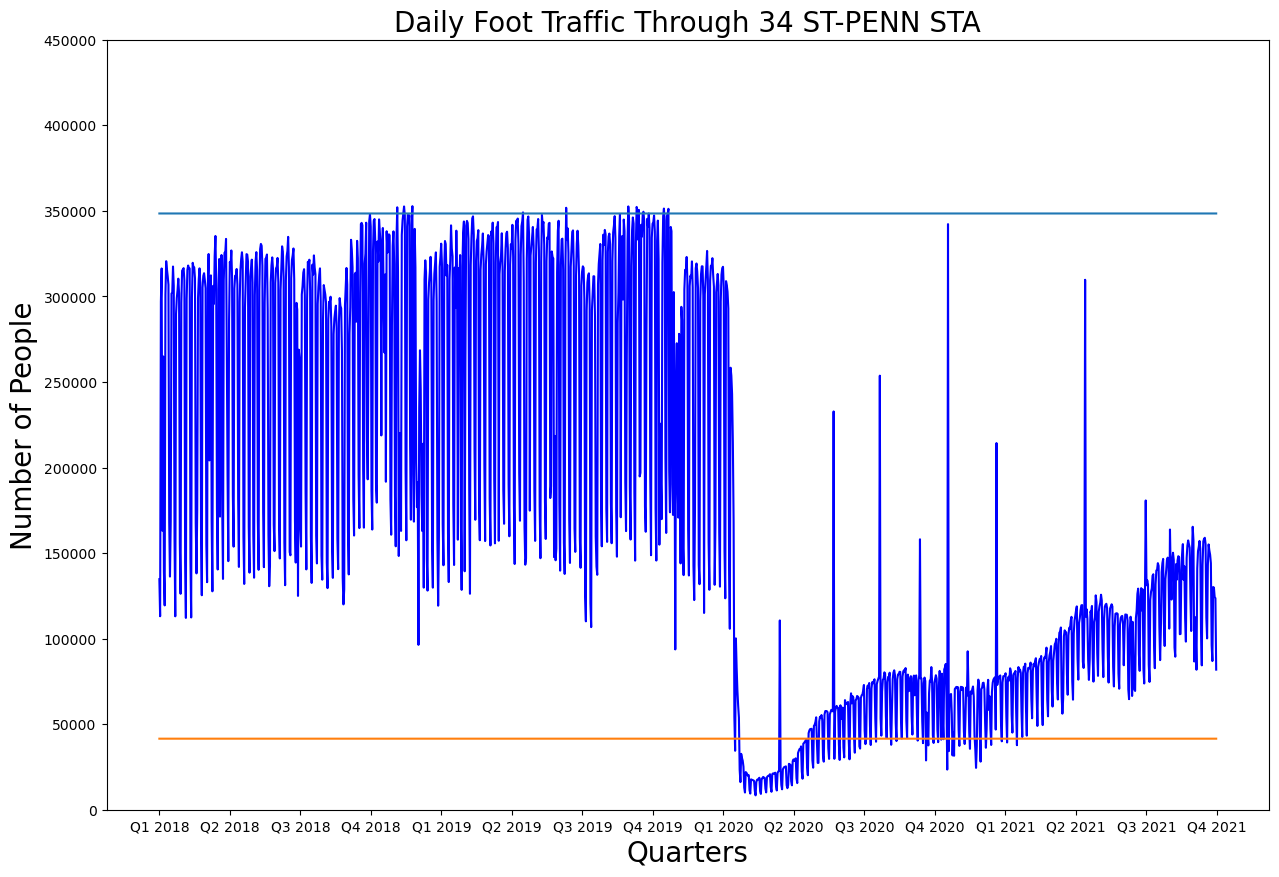

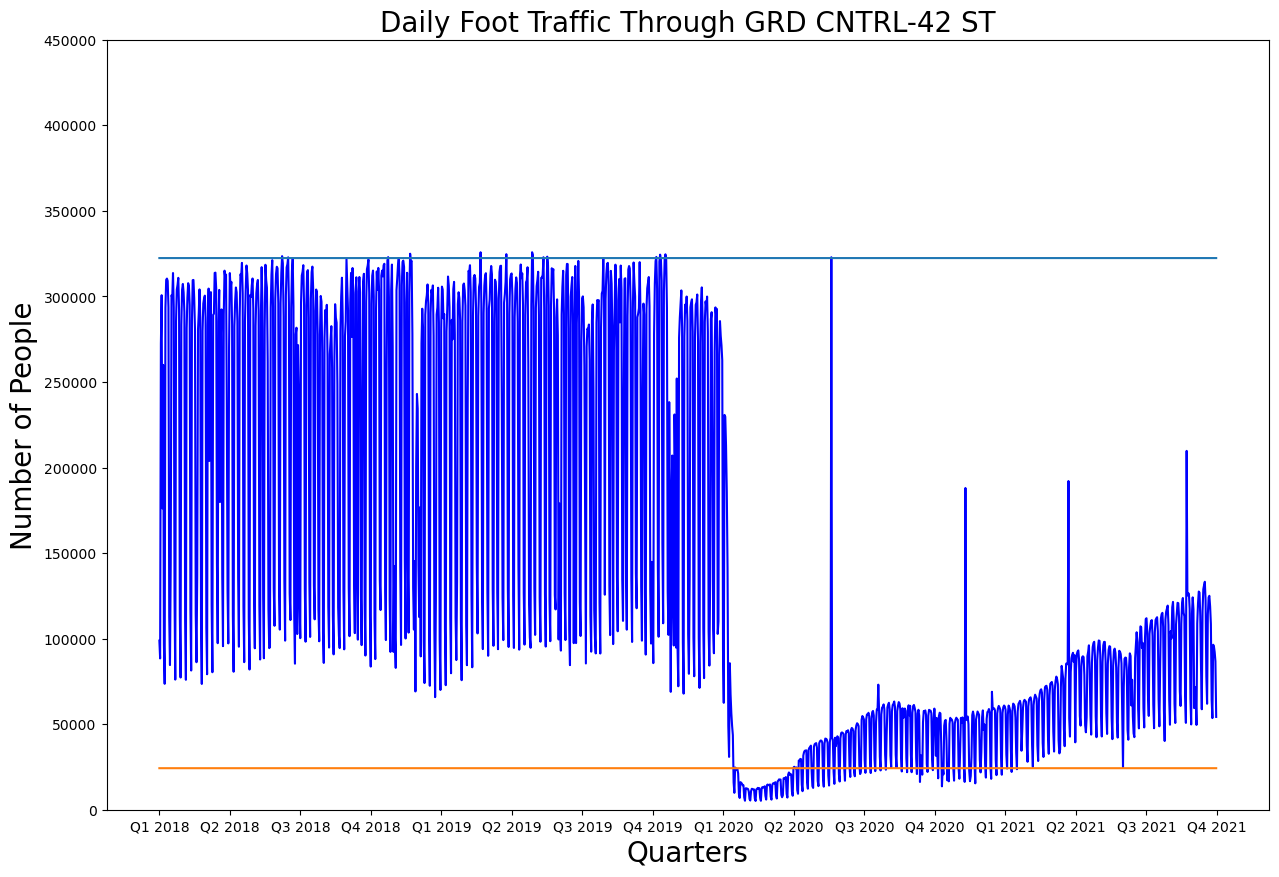

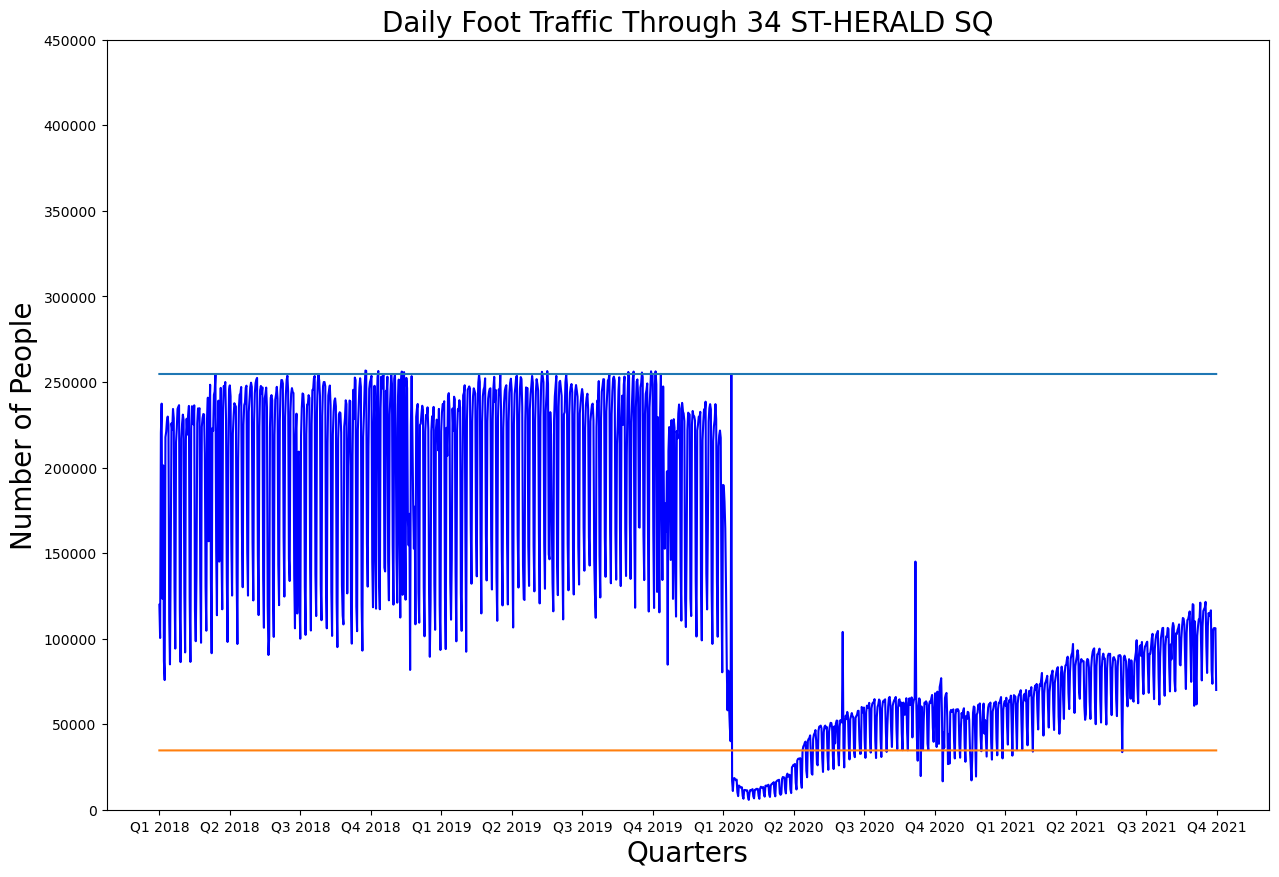

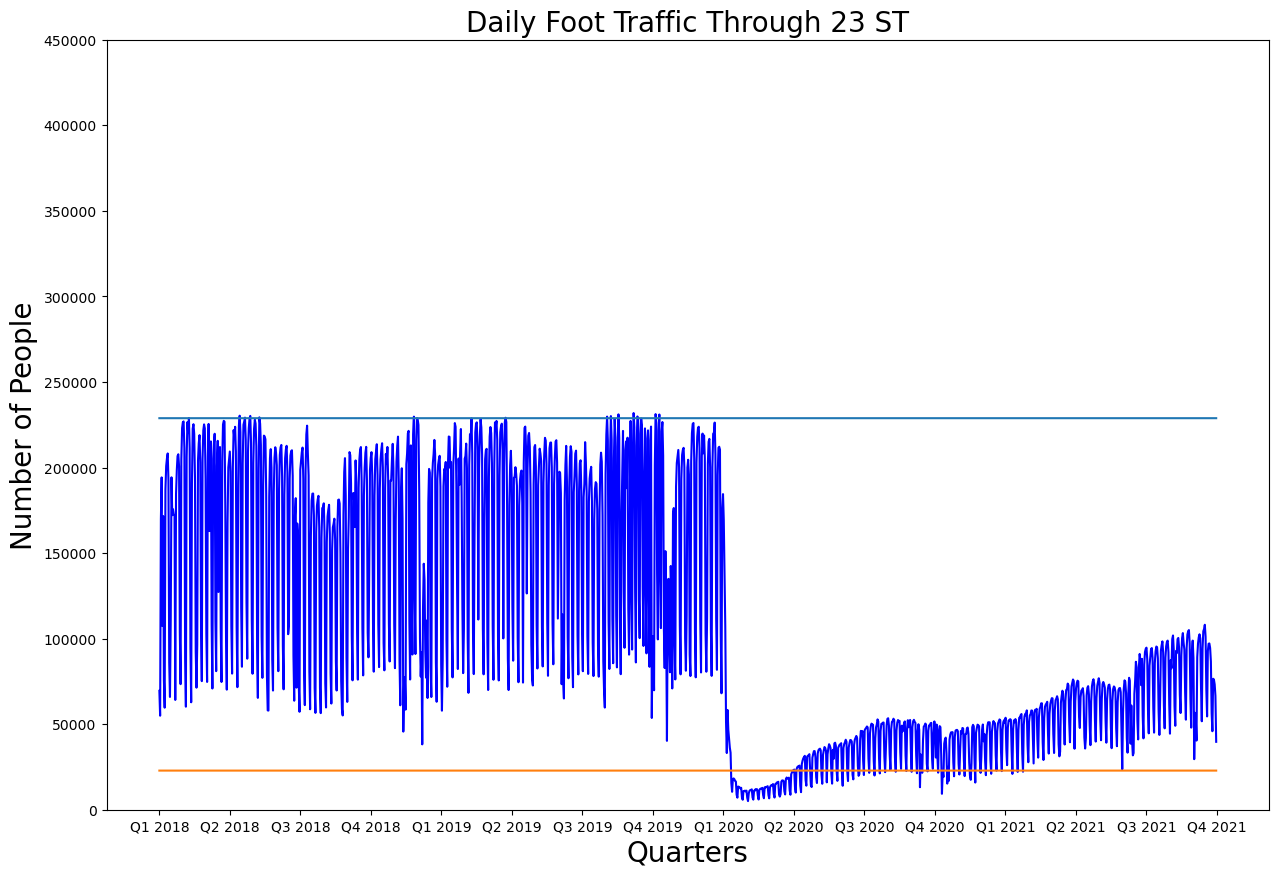

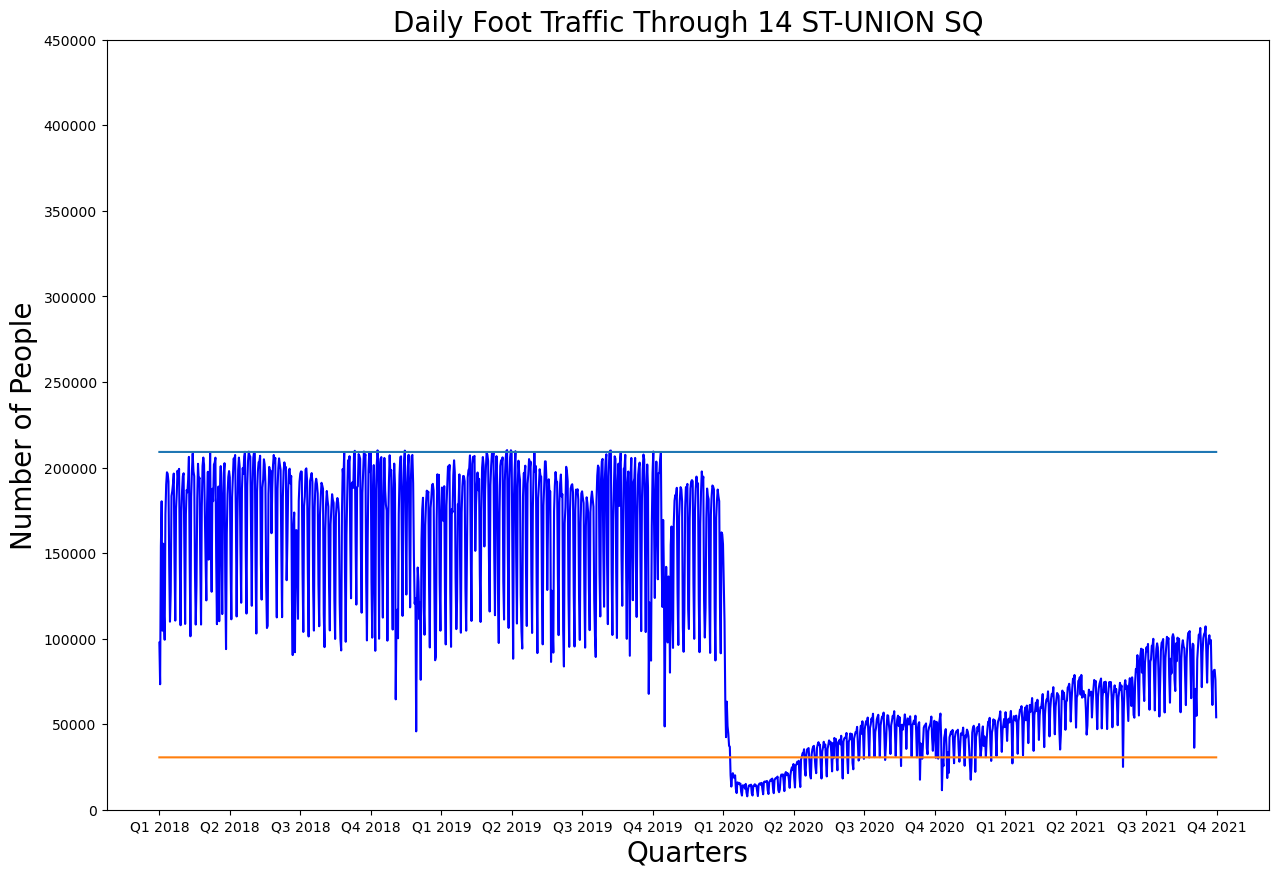

In [74]:
foot_traffic_graph(list_of_stations)

In [76]:
closer_look = clean_df[(clean_df['DATE'] > '2020-01-01') & (clean_df['DATE'] < '2022-01-01')]

In [82]:
# Based on the busiest stations list we got previously 
list_of_stations = ['34 ST-PENN STA', 'GRD CNTRL-42 ST', '34 ST-HERALD SQ', '23 ST', '14 ST-UNION SQ']

#source: https://pylearned.com/SubwayAnalysis/
def foot_traffic_graph(station_list):
    '''This function graphs the foot traffic through a list of stations that are passed in via a list
    args: A list of the stations to be graphed.
    returns: Graphs for the foot traffic for every day the first 6 months of the year 
    '''
    for index, station in enumerate(station_list):
        
        mask = closer_look['STATION'] == station # Selects only the input station
        grouped_station = closer_look[mask].groupby(['STATION', 'DATE'])['TOTAL_TRAFFIC'].sum() # Sums the traffic per day
        filtered_station = grouped_station[grouped_station < grouped_station.quantile(.96)] # Remove outliers
        six_months_station = filtered_station.values[:len(filtered_station)] #grab last 2 yrs 
        #six_months_station = filtered_station.values[:len(filtered_station)//2] # Grab only the first 6 months
        nine_nine = pd.Series(six_months_station).quantile(.99) # Create 99th percentile line
        topper = np.full(len(six_months_station),1)*nine_nine 
        one = pd.Series(six_months_station).quantile(.1) # Create 1 percentile line
        botper = np.full(len(six_months_station),1)*one
    
        plt.figure(figsize=[15,10])
        plt.plot(six_months_station, 'b')
        #ticks_x = np.linspace(0, len(six_months_station), 7)
        ticks_x = np.linspace(0, len(six_months_station), 8)
        #months = ['Jan','Feb','Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
        months = ['Q1 2020','Q2 2020', 'Q3 2020', 'Q4 2020','Q1 2021','Q2 2021', 'Q3 2021', 'Q4 2021']
        #plt.xlabel('Months', fontsize = '20')
        plt.xlabel('Quarters', fontsize = '20')
        plt.ylabel('Number of People', fontsize = '20')
        plt.ylim(0, 450000)
        plt.title('Daily Foot Traffic Through ' + station, fontsize = 20);
        plt.xticks(ticks_x, months);
        plt.plot(topper)
        plt.plot(botper)
        #plt.savefig('FootTrafficThoughStations.png')

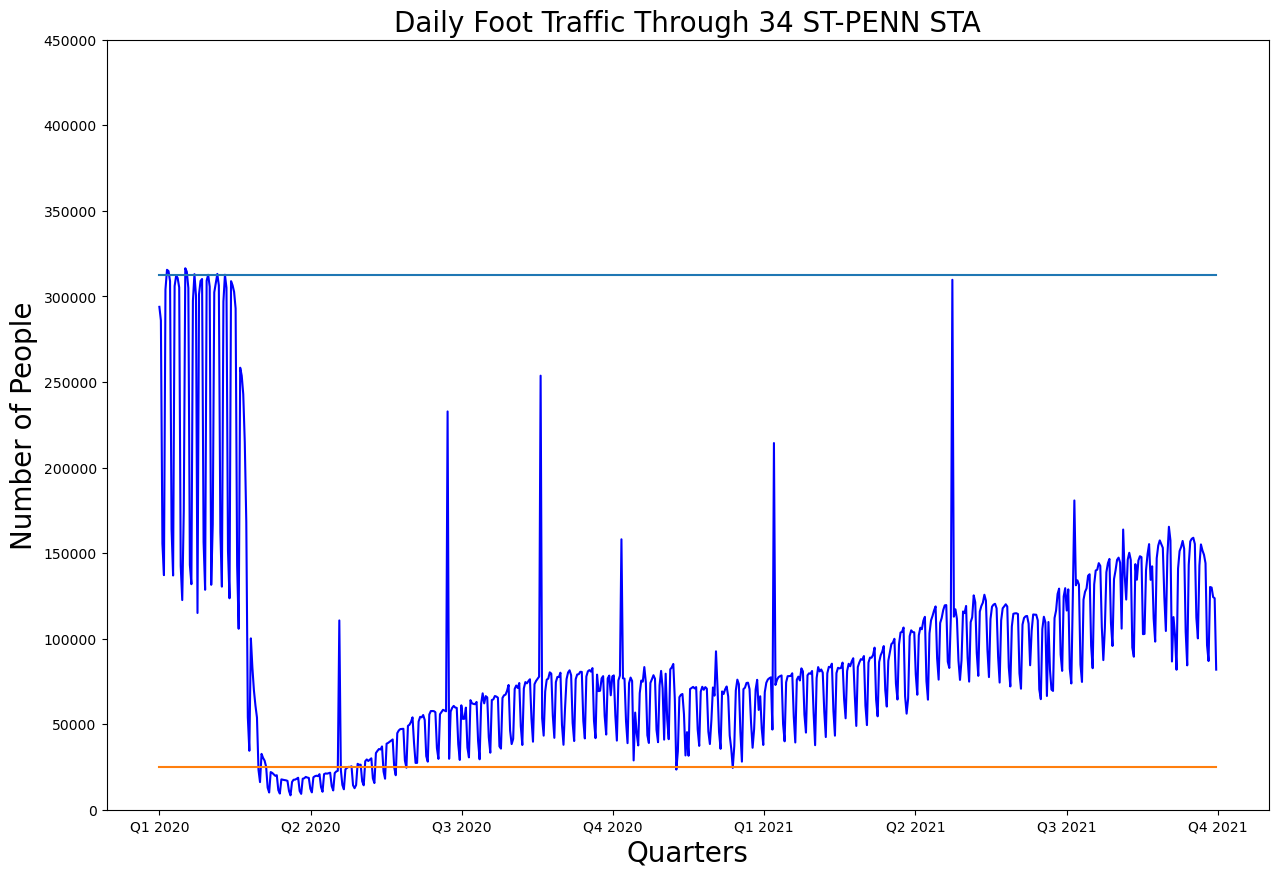

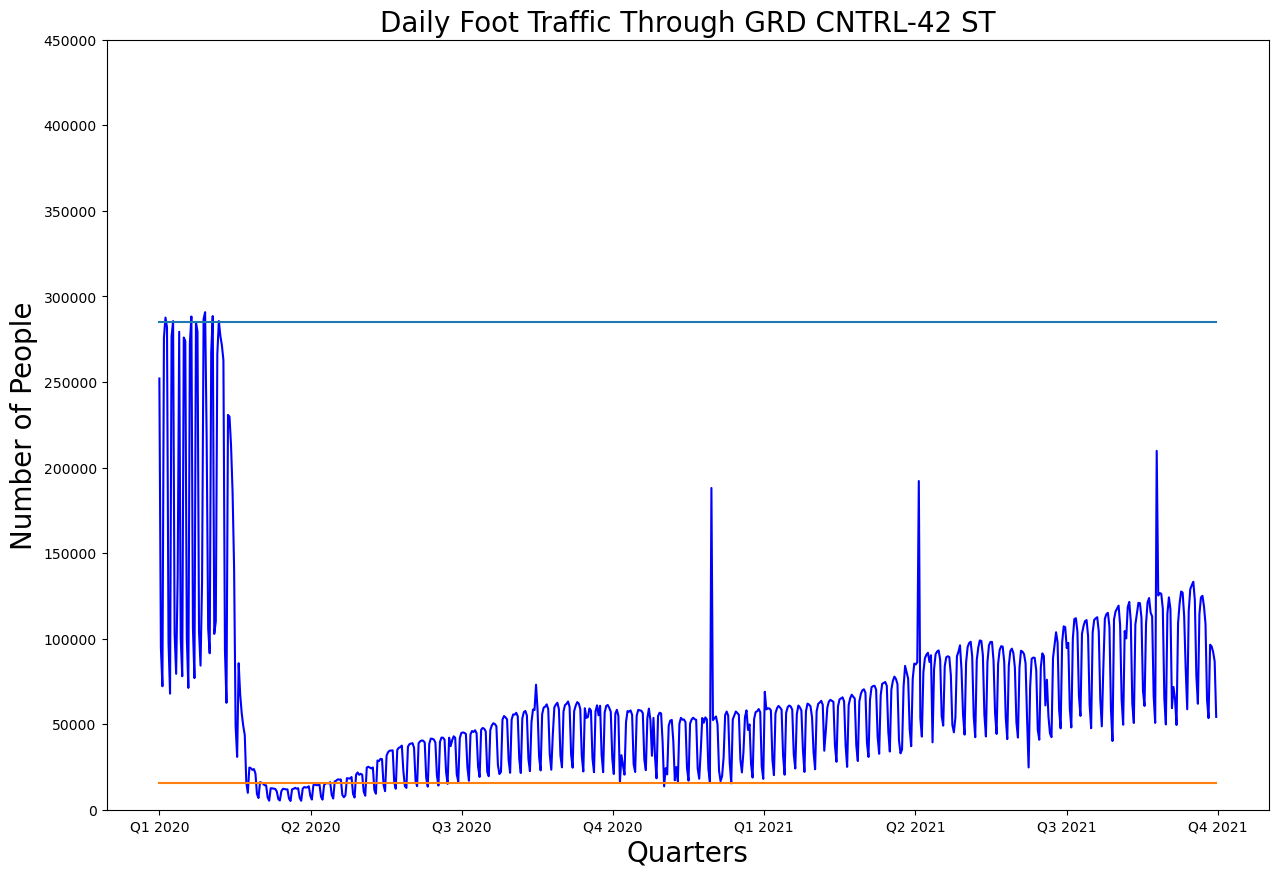

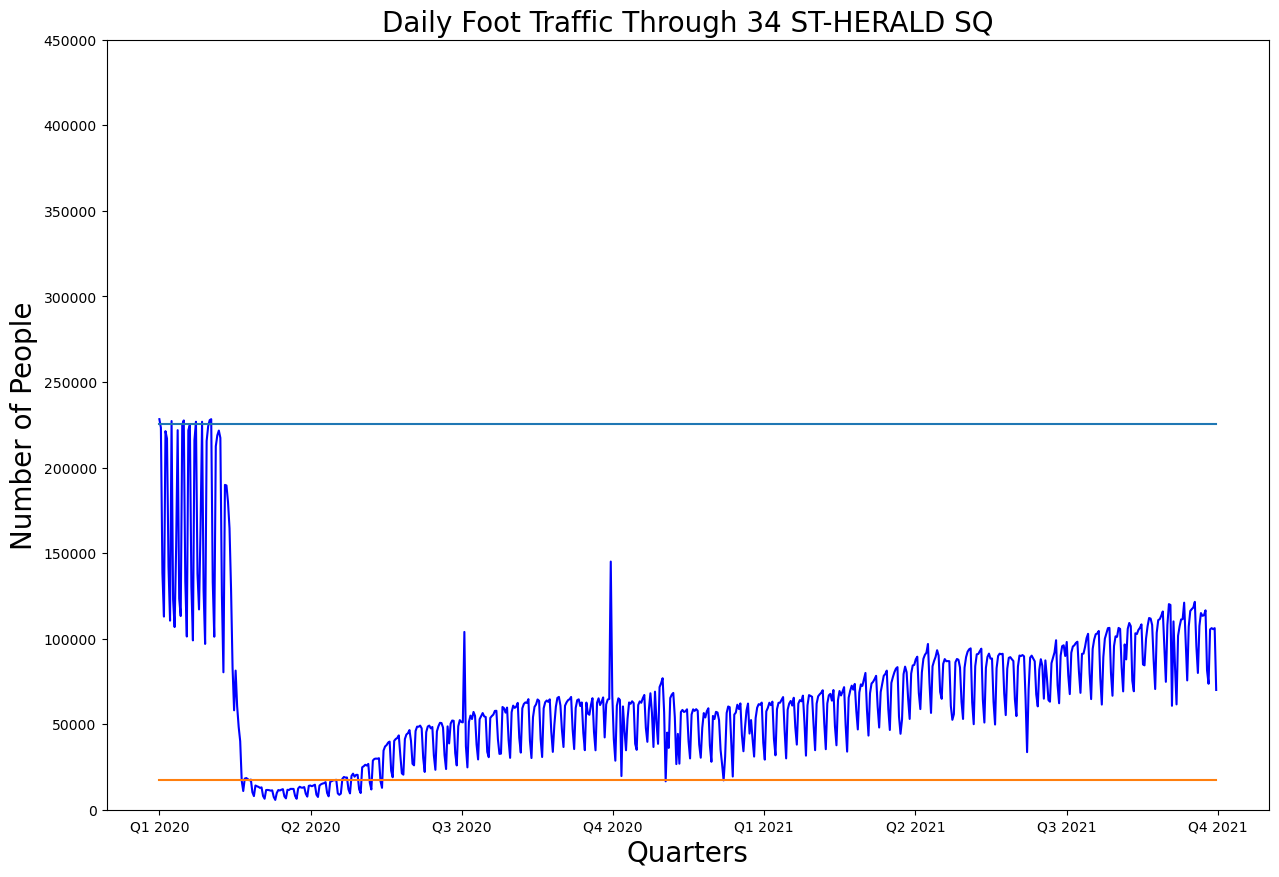

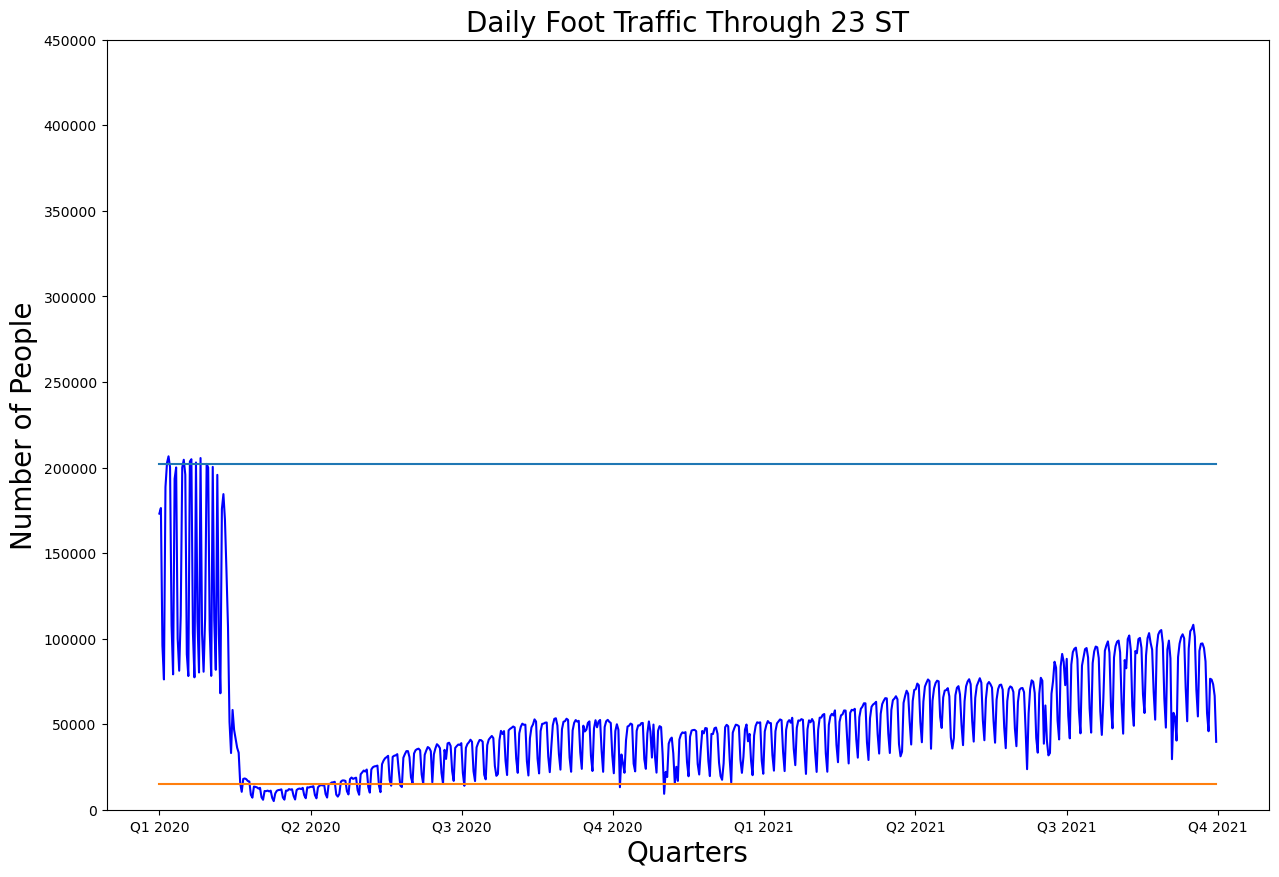

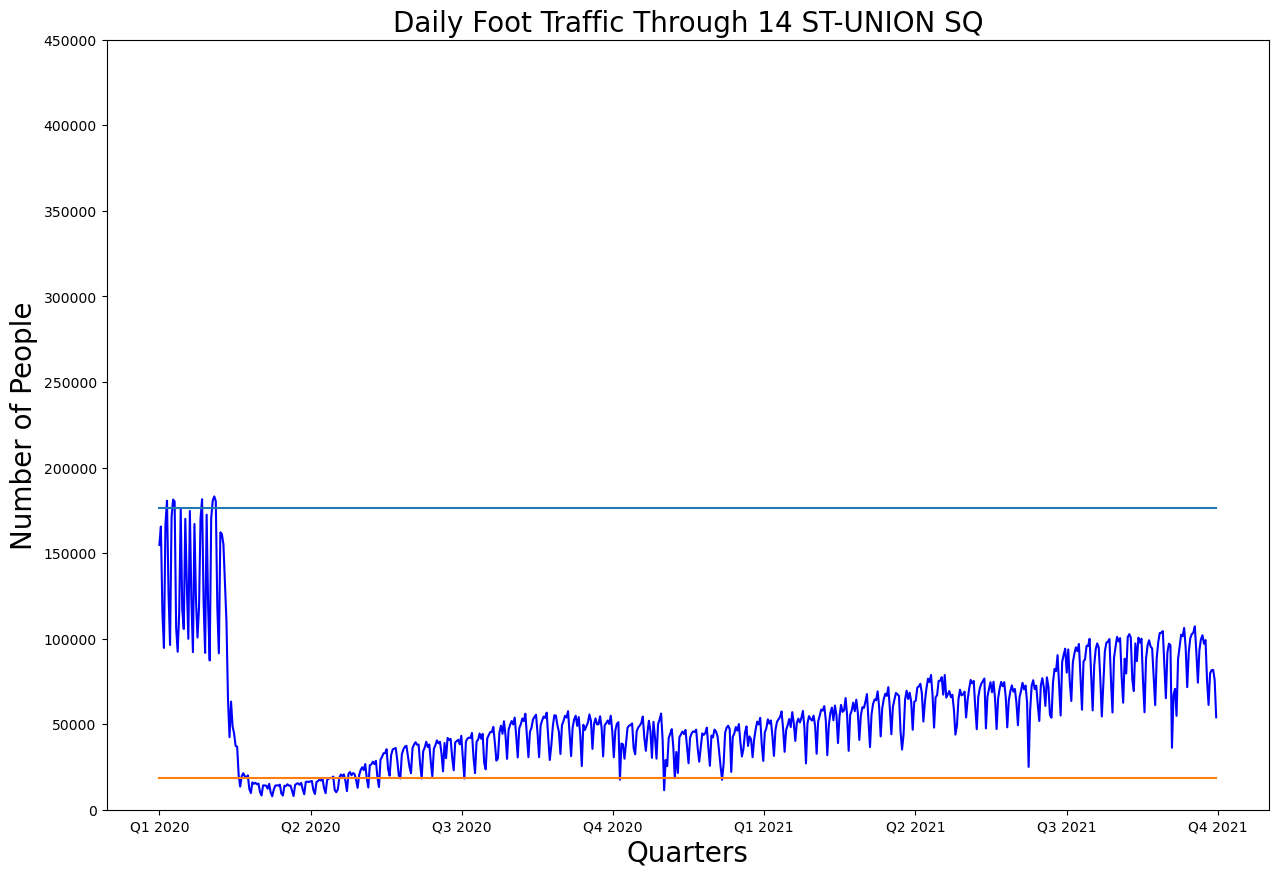

In [85]:
foot_traffic_graph(list_of_stations)

In [ ]:
# Split based on borough 
df1 = df[df['Age'] >= 37]

# Split based on station (only use groupby no need to split?)
df1, df2 = [x for _, x in df.groupby(df['Salary'] < 4528000)]

In [ ]:
# Calculate stations with greatest changes / spikes or drops in visitors 
df['new_col'] = df.sales.diff(periods=30)